In [21]:
import pandas as pd
import folium
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
data_path = 'Data/AFAD_1900_today_31461754_4_9.csv'
df = pd.read_csv(data_path)

In [3]:
print(df.head())

                  Date  Longitude  Latitude  Depth Type  Magnitude Location  \
0  29/04/1903 16:07:56      42.65     39.15   33.0   MS        5.0        -   
1  30/04/1903 04:12:56      42.65     39.15   10.0   MS        4.6        -   
2  03/05/1903 01:56:56      41.50     38.70   10.0   MS        4.9        -   
3  21/05/1903 20:56:56      42.50     39.00   10.0   MS        4.2        -   
4  26/05/1903 08:05:56      29.00     40.65   10.0   MS        5.9        -   

   EventID               TimeName               TypeName  \
0     7821  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
1     7822  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
2     7823      Ayhan ve Diğ.1981      Ayhan ve Diğ.1981   
3     7824  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
4     7825  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   

           MagnitudeName  
0  Ambraseys-Finkel 1987  
1  Ambraseys-Finkel 1987  
2      Ayhan ve Diğ.1981  
3  Ambraseys-Finkel 1987  
4  Ambraseys-Finkel 1987  


In [18]:
def plot_earthquakes_scaled(start_time, end_time):
    # Load the dataset
    data_path = 'Data/AFAD_1900_today_31461754_4_9.csv'
    df = pd.read_csv(data_path)
    
    # Convert the 'Date' to datetime and filter the data
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
    filtered_df = df[(df['Date'] >= pd.to_datetime(start_time)) & (df['Date'] <= pd.to_datetime(end_time))]
    
    # Create a map centered around Turkey
    map_turkey = folium.Map(location=[39.0, 35.0], zoom_start=6)
    
    # Add earthquake markers with scaled sizes
    for idx, row in filtered_df.iterrows():
        # Scale the size of the marker based on the magnitude
        size = max(1, (row['Magnitude'] - 3) / 2)   # Scales up from a base size of 2, minimal size 1
        folium.Circle(
            location=[row['Latitude'], row['Longitude']],
            radius=size * 10000,  # Example scaling factor to adjust visual size
            popup=f"Magnitude: {row['Magnitude']}\nDepth: {row['Depth']} km",
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(map_turkey)
    
    # Display the map
    return map_turkey

In [129]:
map = plot_earthquakes_scaled('2023-02-06', '2023-02-10')
map

In [34]:
def plot_magnitude_histogram(df, start_year, end_year):
    # Ensure 'Date' is a datetime object
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')
    
    # Filter data by year range
    df = df[df['Date'].dt.year.between(start_year, end_year)]
    
    # Define bins for years and magnitudes
    year_bins = np.arange(start_year, end_year + 1)  # One bin per year
    magnitude_bins = np.arange(4.0, 10.0, 0.1)      # Magnitude bins from 4.0 to 9.9
    
    # Create a 2D histogram of counts
    H, xedges, yedges = np.histogram2d(df['Date'].dt.year, df['Magnitude'], bins=[year_bins, magnitude_bins])
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(xedges, yedges, H.T, shading='auto', norm=LogNorm(vmin=1, vmax=H.max()), cmap='viridis')
    plt.colorbar(label='Count of Earthquakes')
    plt.xlabel('Year')
    plt.ylabel('Magnitude [MW]')
    plt.title(f'Earthquake Frequency by Magnitude from {start_year} to {end_year}')
    plt.show()

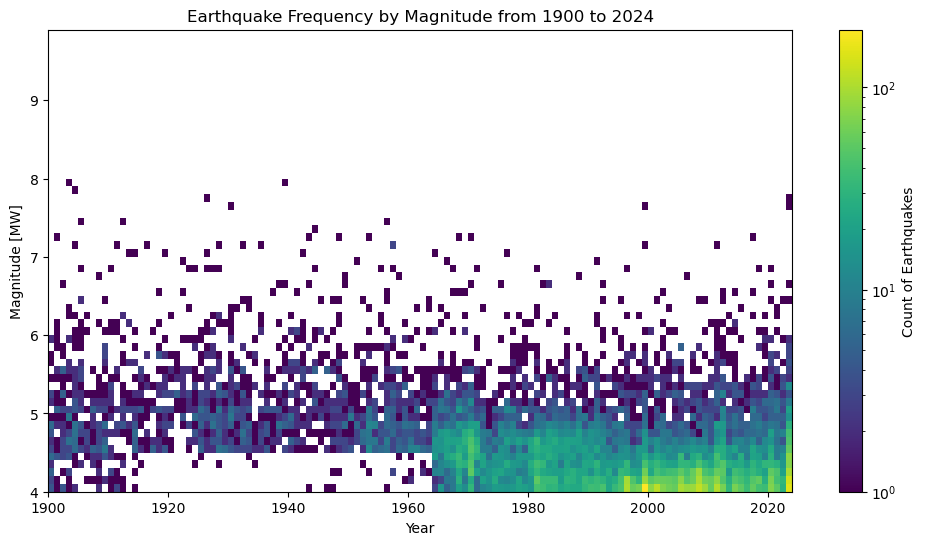

In [35]:
plot_magnitude_histogram(df,1900, 2024)

In [162]:
def homogenize_earthquake_data(df, start_year, end_year, magnitude_bins, year_interval=1, 
                               low_mag_threshold=1, high_mag_threshold=1000):
    # Convert 'Date' to datetime if necessary
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M:%S')

    # Define year bins
    year_bins = np.arange(start_year, end_year + 1, step=year_interval)

    # Initialize an empty DataFrame to store balanced data
    balanced_data = pd.DataFrame()

    # Process data for each year bin
    for year in range(len(year_bins) - 1):
        start_date = f"{year_bins[year]}-01-01"
        end_date = f"{year_bins[year+1] - 1}-12-31"

        # Filter data within the year range
        period_mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
        period_df = df[period_mask]

        # Histogram of counts per magnitude bin for the current period
        counts, _ = np.histogram(period_df['Magnitude'], bins=magnitude_bins)
        
        # Determine the target count for this period
        min_count = np.min(counts) if np.any(counts) else 0

        # Adjust bins to achieve target counts
        for i in range(len(magnitude_bins) - 1):
            bin_mask = (period_df['Magnitude'] >= magnitude_bins[i]) & (period_df['Magnitude'] < magnitude_bins[i+1])
            bin_df = period_df[bin_mask]
            
            # Select the appropriate threshold based on the magnitude bin
            difference_threshold = low_mag_threshold if magnitude_bins[i] < 5.5 else high_mag_threshold
            max_target_count = min_count + difference_threshold

            count_to_sample = min(len(bin_df), max_target_count)
            if count_to_sample > 0:
                sampled_df = bin_df.sample(n=count_to_sample, random_state=42)  # Sampling to target count
                balanced_data = pd.concat([balanced_data, sampled_df])

    return balanced_data.reset_index(drop=True)

In [165]:
magnitude_bins = np.arange(3.0, 9.5, 0.5)
balanced_df = homogenize_earthquake_data(df, 1900, 2020, magnitude_bins)
print(balanced_df.head())

                 Date  Longitude  Latitude  Depth Type  Magnitude Location  \
0 1900-01-18 17:26:56      28.21     37.79   10.0   MS        4.4        -   
1 1900-01-27 04:26:56      37.37     37.63   10.0   MS        4.8        -   
2 1900-01-24 04:56:56      26.14     39.54   10.0   MS        5.2        -   
3 1900-02-06 17:05:56      31.29     38.12   10.0   MS        5.7        -   
4 1900-10-10 10:37:56      29.40     38.80   10.0   MS        5.6        -   

   EventID               TimeName               TypeName  \
0     7697  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
1     7699  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
2     7698  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
3     7701  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   
4     7735  Ambraseys-Finkel 1987  Ambraseys-Finkel 1987   

           MagnitudeName  
0  Ambraseys-Finkel 1987  
1  Ambraseys-Finkel 1987  
2  Ambraseys-Finkel 1987  
3  Ambraseys-Finkel 1987  
4  Ambraseys-Finkel 1987  


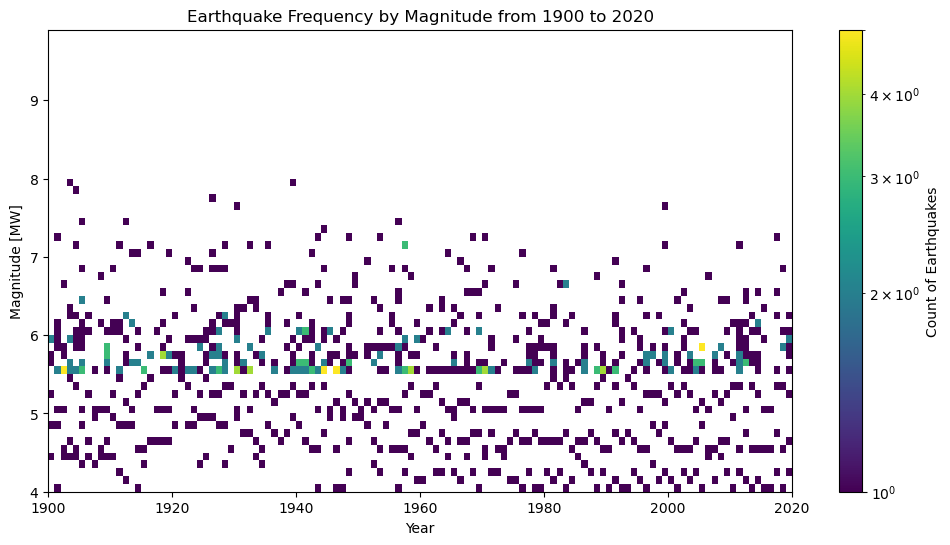

In [166]:
plot_magnitude_histogram(balanced_df,1900, 2020)